In [96]:
import os
import pandas as pd
import xarray as xr
import numpy as np
import pickle
import matplotlib.pyplot as plt
%run _Val_Mapping.ipynb
import datetime

In [51]:
# Test data set #
# Skip this box when actually processing #
##########################################

ds = xr.open_dataset('/data/artemis/observations/SOCCOM/SOCCOM_HRQC_CANYON_netcdf_20210216/11090SOOCN_HRQC.nc')
            
lats = ds.Lat # (profile)
lons = ds.Lon # (profile)
depths = ds.Depth # (profile, level)
spco2 = ds.pCO2_CANY # (profile,level) #I chose to use the CANYON version
days = ds.JULD # (profile)

In [58]:
# Initialize Lists to go into our dataframe #

lat = [] # profile location
lon = [] # profile location
pco2 = [] # average pco2 above 10m
depth = [] # average depth of pco2 measurements above 10m
cnt = []   # number of pco2 measurements above 10m
dates = [] # date of profile
types = []  # don't lose track of which file this value came from 
folder = [] # folder of observations

df = pd.DataFrame()

Loop over all the files in the directories for SOCCOM

In [61]:
parentdir = '/data/artemis/observations/SOCCOM'
directories = [f'{parentdir}/SOCCOM_HRQC_CANYON_netcdf_20210216',f'{parentdir}/SOCCOM_HRQC_LIAR_netcdf_20210216',f'{parentdir}/SOCCOM_HRQC_MLR_netcdf_20210216']
target = ['pCO2_CANY','pCO2_LIAR','pCO2_MLR']
folders = ['CANYON','LIAR','MLR']

ftype = -1

for direc in directories:   # 3 folders
    
    ftype += 1
    
    print(direc)
    
    for filename in os.listdir(direc): # loop on every netcdf file
        if filename.endswith(".nc"):   # skip README.txt
            
            ds = xr.open_dataset(f'{direc}/{filename}')  # open the file
            
            if target[ftype] in ds.keys():
                
                lats = ds.Lat   # (profile)
                lons = ds.Lon   # (profile)
                depths = ds.Depth   # (profile, level)
                days = ds.JULD  # (profile)
                
                ##############################################
                # pco2 different labels in each directory:
                ##############################################
                spco2 = ds[target[ftype]]   # (profile,level)
            
                for i in range(0,len(lats)):     # loop on profiles
                    
                    fin = (np.isnan(depths[i,:]))
                    depths[i,fin] = 1000
                    
                    fid = ((depths[i,:].values < 10) & (~np.isnan(spco2[i,:].values)))  # find surface measurements (above 10m)
            
                    if fid.sum() > 0:                # if there are surface measurements, calculate and append to our list
                        lt = lats[i].values
                        ln = lons[i].values
                        dtmp = np.nanmean(depths[i,fid].values)
                        cnts = fid.sum()
                        ptmp = np.nanmean(spco2[i,fid].values)
                        lat.append(lt)
                        lon.append(ln)
                        cnt.append(cnts)
                        pco2.append(ptmp)
                        depth.append(dtmp)
                        dates.append(days[i].values)   
                        types.append(f'{filename}')
                        folder.append(folders[ftype])

/data/artemis/observations/SOCCOM/SOCCOM_HRQC_CANYON_netcdf_20210216
/data/artemis/observations/SOCCOM/SOCCOM_HRQC_LIAR_netcdf_20210216
/data/artemis/observations/SOCCOM/SOCCOM_HRQC_MLR_netcdf_20210216


In [62]:
# Write to DataFrame    #
#########################
df['lat']=lat
df['lon']=lon
df['pco2']=pco2
df['depth']=depth
df['count']=cnt
df['date']=dates
df['file']=types
df['folder']=folder

df.head()

,lat,lon,pco2,depth,count,date,file,folder
0,-67.51,171.939,425.60,7.8410,1,2017-04-19 06:42:00.000000768,12378SOOCN_HRQC.nc,CANYON
1,-67.676,171.651,406.20,7.1480,1,2017-04-29 07:24:59.999997696,12378SOOCN_HRQC.nc,CANYON
2,-53.513,0.015,403.15,7.4035,2,2014-12-11 12:16:59.999999488,9096SOOCN_HRQC.nc,CANYON
3,-53.504,0.129,380.20,7.7310,1,2014-12-21 18:53:59.999997952,9096SOOCN_HRQC.nc,CANYON
4,-53.49,0.209,400.70,6.6305,2,2015-01-01 02:51:59.999998464,9096SOOCN_HRQC.nc,CANYON


In [68]:
# Now we need to grid these observations #
##########################################
##########################################
# Grab ML grid #
################
dm = xr.open_dataset('/data/artemis/workspace/vbennington/SOCAT_ML/dpco2/models/reconstructions/xg/Gregor1/xg_recon_dpCO2_2D_mon_1x1_198201-201912.nc')
ylat = dm.ylat
xlon = dm.xlon

<xarray.DataArray 'xlon' (xlon: 360)>
array([-179.5, -178.5, -177.5, ...,  177.5,  178.5,  179.5])
Coordinates:
  * xlon     (xlon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
359.994


In [71]:
# To Get Nearest Grid Cell #
# First move longitudes > 180 to (long - 360)
fil = (df.lon > 180)
df.lon[fil] = df.lon[fil] - 360

/home/vbennington/.conda/envs/dev2/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [76]:
xxlon,yylat = np.meshgrid(xlon,ylat)

In [88]:
gridlat=[]
gridlon=[]

for i in range(0,len(df.lat)):
    tlat = df.lat[i]
    tlon = df.lon[i]
    dist1 = np.abs(yylat-tlat)
    dist2 = np.abs(xxlon-tlon)
    c = np.maximum(dist2,dist1)
    y, x = np.where(c == np.min(c))
    gridlat.append(yylat[y[0],x[0]])
    gridlon.append(xxlon[y[0],x[0]])

In [90]:
df['gridlat']=gridlat
df['gridlon']=gridlon
df.tail(10)

,lat,lon,pco2,depth,count,date,file,folder,gridlat,gridlon
18813,-46.78,69.815,395.5,7.735,1,2020-11-15 11:43:59.999996928,18821SOOCN_HRQC.nc,MLR,-46.5,69.5
18814,-46.894,71.495,329.6,7.616,1,2020-11-25 17:48:00.000002560,18821SOOCN_HRQC.nc,MLR,-46.5,71.5
18815,-47.117,71.684,340.0,7.705,1,2020-12-05 23:51:00.000002048,18821SOOCN_HRQC.nc,MLR,-47.5,71.5
18816,-47.019,72.916,288.6,7.497,1,2020-12-16 06:22:00.000001792,18821SOOCN_HRQC.nc,MLR,-47.5,72.5
18817,-47.789,72.995,302.9,7.923,1,2020-12-26 12:34:59.999995648,18821SOOCN_HRQC.nc,MLR,-47.5,72.5
18818,-47.958,73.056,375.6,7.834,1,2021-01-05 18:48:59.999995648,18821SOOCN_HRQC.nc,MLR,-47.5,73.5
18819,-47.876,72.687,383.3,7.834,1,2021-01-16 00:47:59.999999232,18821SOOCN_HRQC.nc,MLR,-47.5,72.5
18820,-47.851,72.704,383.8,7.625,1,2021-01-26 07:27:00.000000768,18821SOOCN_HRQC.nc,MLR,-47.5,72.5
18821,-47.82,74.231,395.7,7.754,1,2021-02-05 13:41:59.999997440,18821SOOCN_HRQC.nc,MLR,-47.5,74.5
18822,-48.517,75.295,401.1,7.843,1,2021-02-15 19:52:00.000001792,18821SOOCN_HRQC.nc,MLR,-48.5,75.5


In [122]:
month = []
day = []
year = []

for i in range(0,len(df['date'])):
    d = df['date'][i]
    tmpd = d.date()
    month.append(tmpd.month)
    day.append(tmpd.day)
    year.append(tmpd.year)

In [123]:
df['year']=year
df['month']=month
df['day']=day

In [124]:
df.head(10)

,lat,lon,pco2,depth,count,date,file,folder,gridlat,gridlon,year,month,day
0,-67.51,171.939,425.60,7.8410,1,2017-04-19 06:42:00.000000768,12378SOOCN_HRQC.nc,CANYON,-67.5,171.5,2017,4,19
1,-67.676,171.651,406.20,7.1480,1,2017-04-29 07:24:59.999997696,12378SOOCN_HRQC.nc,CANYON,-67.5,171.5,2017,4,29
2,-53.513,0.015,403.15,7.4035,2,2014-12-11 12:16:59.999999488,9096SOOCN_HRQC.nc,CANYON,-53.5,0.5,2014,12,11
3,-53.504,0.129,380.20,7.7310,1,2014-12-21 18:53:59.999997952,9096SOOCN_HRQC.nc,CANYON,-53.5,0.5,2014,12,21
4,-53.49,0.209,400.70,6.6305,2,2015-01-01 02:51:59.999998464,9096SOOCN_HRQC.nc,CANYON,-53.5,0.5,2015,1,1
5,-53.489,0.314,401.50,6.6400,1,2015-01-11 09:10:00.000004352,9096SOOCN_HRQC.nc,CANYON,-53.5,0.5,2015,1,11
6,-53.546,0.363,396.00,7.8200,1,2015-01-21 16:13:00.000000512,9096SOOCN_HRQC.nc,CANYON,-53.5,0.5,2015,1,21
7,-53.588,0.359,389.30,6.7390,1,2015-02-01 01:02:59.999995904,9096SOOCN_HRQC.nc,CANYON,-53.5,0.5,2015,2,1
8,-53.607,0.394,402.40,7.4530,1,2015-02-11 09:14:00.000000256,9096SOOCN_HRQC.nc,CANYON,-53.5,0.5,2015,2,11
9,-53.585,0.389,394.90,5.1040,1,2015-02-21 17:28:00.000003840,9096SOOCN_HRQC.nc,CANYON,-53.5,0.5,2015,2,21


In [119]:
# Write intermediate step to file:
################################################################################
df.to_csv('/data/artemis/observations/SOCCOM/processed/SOCCOM_allpco2_10m.csv')

In [144]:
df2 = df.groupby(['gridlat','gridlon','year','month']).mean()
df2.head()

pco2     depth  count   day
gridlat gridlon year month                                   
-75.5   -157.5  2017 3      319.900000  7.689000    1.0   4.0
                     4      349.033333  4.849000    1.0   3.0
        -156.5  2017 1      226.816667  6.279000    1.0  18.0
                     2      304.766667  7.705667    1.0  12.0
-74.5   -161.5  2018 1      376.583333  7.466500    1.0  18.0

In [169]:
gridded_pco2 = np.empty(shape=(864,180,360))

# Get monthly values gridded #
##############################

ticker = -1

for yr in range(1950,2022):
    for m in range(1,13):
        fiym = ((df2.index.get_level_values('year')==yr) & (df2.index.get_level_values('month')==m))
        
        ticker += 1
        
        if fiym.sum() > 0:             # have at least one observation this year/month
            lat_fiym = df2.index.get_level_values('gridlat')[fiym].values
            lon_fiym = df2.index.get_level_values('gridlon')[fiym].values
            pco2_fiym = df2['pco2'][fiym].values
                  
            for j in range(0,len(lat_fiym)):
                tlat = lat_fiym[j]
                tlon = lon_fiym[j]
                ptmp = pco2_fiym[j]
                
                fix = ((yylat==tlat) & (xxlon==tlon))
                gridded_pco2[ticker,fix] = ptmp

In [174]:
fizero = (gridded_pco2 == 0)
gridded_pco2[fizero] = np.nan

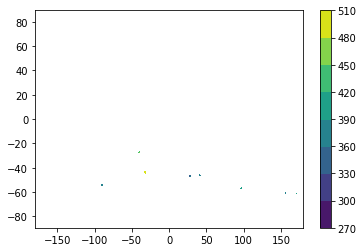

In [179]:
fig=plt.figure()
plt.contourf(xxlon,yylat,gridded_pco2[840,:,:])
plt.colorbar()

/home/vbennington/.conda/envs/dev2/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


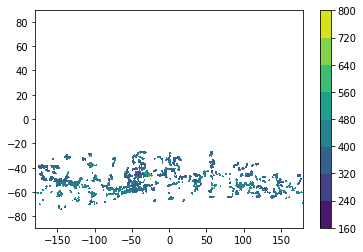

In [182]:
fig=plt.figure()
plt.contourf(xxlon,yylat,np.nanmean(gridded_pco2,axis=0))
plt.colorbar()

In [184]:
date_range_start = '1950-01-01T00:00:00.000000000'
date_range_end = '2021-12-31T00:00:00.000000000'

# create date vector
dates = pd.date_range(start=date_range_start, 
                      end=date_range_end,freq='MS') + np.timedelta64(14, 'D')

print(dates)

DatetimeIndex(['1950-01-15', '1950-02-15', '1950-03-15', '1950-04-15',
               '1950-05-15', '1950-06-15', '1950-07-15', '1950-08-15',
               '1950-09-15', '1950-10-15',
               ...
               '2021-03-15', '2021-04-15', '2021-05-15', '2021-06-15',
               '2021-07-15', '2021-08-15', '2021-09-15', '2021-10-15',
               '2021-11-15', '2021-12-15'],
              dtype='datetime64[ns]', length=864, freq=None)


In [185]:
dp_out = xr.Dataset({
                        'spco2':(["time","ylat","xlon"],gridded_pco2)},
                        coords={'time': (['time'],dates),
                        'ylat': (['ylat'],ylat),
                        'xlon':(['xlon'],xlon)})
        
# Save to netcdf
dp_out.to_netcdf('/data/artemis/observations/SOCCOM/processed/SOCCOM_gridded_spco2_mon_195001-202112.nc') 